# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import genfromtxt
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv


# Loading datasets

In [2]:
calendar_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_price_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
sales_train_validation = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sample_submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

# Exploratory Data Analysis

## Sales Train Validation

In [3]:
sales_train_validation.shape

(30490, 1919)

In [4]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Sepererer Data om hvor meget der er solgt en dag i en liste, væk fra de andre kolonner i sales_train_validation, ved at sortere på string segmentet 'd_'

In [5]:
date_col = [col for col in sales_train_validation if col.startswith('d_')]

In [6]:
len(date_col)

1913

In [7]:
sales_train_validation.state_id.value_counts()

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64

Finder total mængde af varer solgt pr vare

In [8]:
sales_train_validation['total_sales'] = sales_train_validation[date_col].sum(axis=1)

In [9]:
sales_train_validation['total_sales'].head()

0     600
1     493
2     288
3    3288
4    1849
Name: total_sales, dtype: int64

Totalt salg pr stat, i antal af varer.

In [10]:
sales_train_validation.groupby('state_id').agg({"total_sales":"sum"}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64


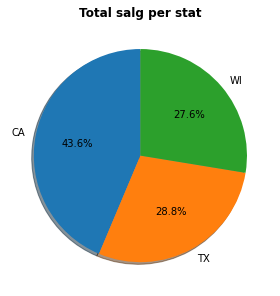

In [11]:
print(sales_train_validation.state_id.value_counts())
#Tilføj ny kolonne til dataset med total salg (summen af alle dato kolonner)
sales_train_validation['total_sales'] = sales_train_validation[date_col].sum(axis=1)
#Calculating the sales ratio
total_salg_per_stat = sales_train_validation.groupby('state_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
total_salg_per_stat = total_salg_per_stat.reset_index()
#Plotting the sales ratio
fig1, ax1 = plt.subplots()
#Opret et nyt pie chart vha. matplotlib
ax1.pie(total_salg_per_stat['total_sales'],labels= total_salg_per_stat['state_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.title("Total salg per stat",fontweight = "bold")
plt.show()

Totalt salg af varer pr butik

  store_id  total_sales
0     CA_1      7698216
1     CA_2      5685475
2     CA_3     11188180
3     CA_4      4103676
4     TX_1      5595292
5     TX_2      7214384
6     TX_3      6089330
7     WI_1      5149062
8     WI_2      6544012
9     WI_3      6427782


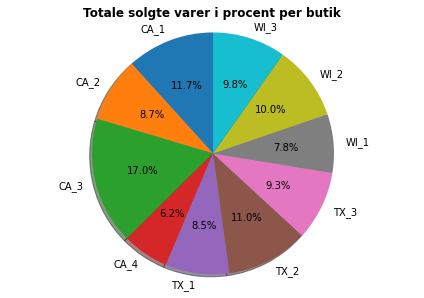

In [12]:
print(sales_train_validation.groupby('store_id').agg({"total_sales":"sum"}).reset_index())

#Finder den totale salgsrate fordelt på de enkelte butikker
total_salg_per_butik=sales_train_validation.groupby('store_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
#Lav et piechart som viser fordelingen i procent
total_salg_per_butik = total_salg_per_butik.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(total_salg_per_butik['total_sales'],labels= total_salg_per_butik['store_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Totale solgte varer i procent per butik",fontweight = "bold")
plt.show()

Totalt salg fordelt i kategorier

      cat_id  total_sales
0      FOODS     45089939
1    HOBBIES      6124800
2  HOUSEHOLD     14480670


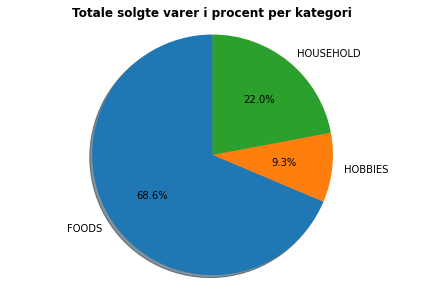

In [13]:
print(sales_train_validation.groupby('cat_id').agg({"total_sales":"sum"}).reset_index())

#Finder den totale salgsrate fordelt på de enkelte kategorier
total_salg_per_kategori = sales_train_validation.groupby('cat_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
total_salg_per_kategori = total_salg_per_kategori.reset_index()
#Lav et piechart som viser fordelingen i procent
fig1, ax1 = plt.subplots()
ax1.pie(total_salg_per_kategori['total_sales'],labels= total_salg_per_kategori['cat_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Totale solgte varer i procent per kategori",fontweight = "bold")
plt.show()

In [14]:
sales_train_validation.groupby(['state_id','cat_id']).agg({"total_sales":"sum"}).reset_index()

,state_id,cat_id,total_sales
0,CA,FOODS,19196302
1,CA,HOBBIES,3039883
2,CA,HOUSEHOLD,6439362
3,TX,FOODS,12956421
4,TX,HOBBIES,1592339
5,TX,HOUSEHOLD,4350246
6,WI,FOODS,12937216
7,WI,HOBBIES,1492578
8,WI,HOUSEHOLD,3691062


Salg af varer efter dept_id

       dept_id  total_sales
0      FOODS_1      5088041
1      FOODS_2      7629822
2      FOODS_3     32372076
3    HOBBIES_1      5596460
4    HOBBIES_2       528340
5  HOUSEHOLD_1     11500526
6  HOUSEHOLD_2      2980144


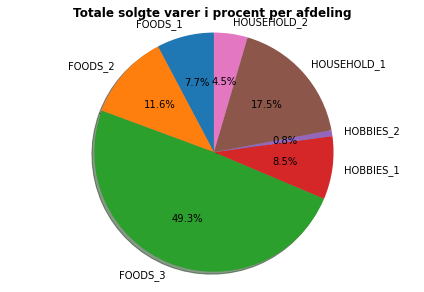

In [15]:
dept_sales = sales_train_validation.groupby('dept_id').agg({"total_sales":"sum"}).reset_index()
print(dept_sales)
#Finder den totale salgsrate fordelt på de enkelte afdelinger
total_salg_per_afdeling = sales_train_validation.groupby('dept_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
#Lav et piechart som viser fordelingen i procent
total_salg_per_afdeling = total_salg_per_afdeling.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(total_salg_per_afdeling['total_sales'],labels= total_salg_per_afdeling['dept_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Totale solgte varer i procent per afdeling",fontweight = "bold")
plt.show()

## Sell Price Data

In [16]:
sell_price_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [17]:
sell_price_data.groupby(['store_id', 'item_id']).agg({"sell_price": ["max", "min"]}).reset_index()

store_id          item_id sell_price       
                                       max    min
0         CA_1      FOODS_1_001       2.24   2.00
1         CA_1      FOODS_1_002       9.48   7.88
2         CA_1      FOODS_1_003       3.23   2.88
3         CA_1      FOODS_1_004       1.96   1.50
4         CA_1      FOODS_1_005       3.54   2.94
...        ...              ...        ...    ...
30485     WI_3  HOUSEHOLD_2_512       3.97   3.97
30486     WI_3  HOUSEHOLD_2_513       2.78   2.78
30487     WI_3  HOUSEHOLD_2_514      19.54  17.94
30488     WI_3  HOUSEHOLD_2_515       1.97   1.97
30489     WI_3  HOUSEHOLD_2_516       5.94   5.94

[30490 rows x 4 columns]

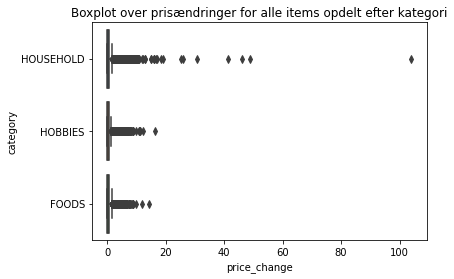

In [18]:
#Undersøgelse af prisændringer for de enkelte items over tid, med min og max værdier
#Aggregerer min og max prisværdier for de enkelte items i hver butik
item_store_prices = sell_price_data.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
#print(item_store_prices.head())
#Ændre navn på kolonner for min og max værdier
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]
#Tilføjer en ny 'price change' kolonne med prisændring for hver item per butik
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
#print(item_store_prices.head())
#Laver en ny data frame med værdierne sorteret efter prisændring
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
#Tilføjer en ny kolonne 'category' med navnet for kategorien per item
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]
#print(item_store_prices_sorted.head())
#Boxplot af prisændringer ved brug af seaborn
sns.boxplot(x="price_change", y="category", data=item_store_prices_sorted)
title = plt.title("Boxplot over prisændringer for alle items opdelt efter kategori")

## Calendar Data

In [19]:
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [20]:
calendar_data.shape

(1969, 14)

Pivot er en omdannelse af vores dataframe snap_days så vores år bliver til kolonner, og index'et bliver til måneden. 

## Snap Days

In [21]:
snap_days = calendar_data.groupby(['year','month'])['snap_CA','snap_TX','snap_WI'].sum().reset_index()
snap_days.pivot(index="month",columns = "year",values = ["snap_CA","snap_TX","snap_WI"])

snap_CA                               snap_TX                          \
year     2011  2012  2013  2014  2015  2016    2011  2012  2013  2014  2015   
month                                                                         
1         0.0  10.0  10.0  10.0  10.0  10.0     0.0  10.0  10.0  10.0  10.0   
2        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
3        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
4        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
5        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
6        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
7        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
8        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
9        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
10       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
11       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
12       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   

            snap_WI                                
year   2016    2011  2012  2013  2014  2015  2016  
month                                              
1      10.0     0.0  10.0  10.0  10.0  10.0  10.0  
2      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
3      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
4      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
5      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
6      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
7       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
8       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
9       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
10      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
11      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
12      NaN    10.0  10.0  10.0  10.0  10.0   NaN

In [22]:
start_date = datetime.datetime(2011,1,29)

In [23]:
sales_sum = pd.DataFrame(sales_train_validation[date_col].sum(axis =0),columns = ["sales"])


In [24]:
#tilføjer dato kolonne vha. for in range loop
sales_sum['date'] = [start_date + datetime.timedelta(days=x) for x in range(1913)]
sales_sum.set_index('date', drop=True, inplace=True)
print(sales_sum)

            sales
date             
2011-01-29  32631
2011-01-30  31749
2011-01-31  23783
2011-02-01  25412
2011-02-02  19146
...           ...
2016-04-20  35343
2016-04-21  35033
2016-04-22  40517
2016-04-23  48962
2016-04-24  49795

[1913 rows x 1 columns]


## Yearly overall sales

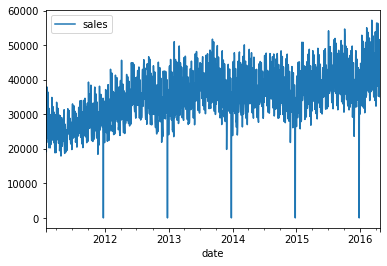

In [25]:
sales_sum.plot()

Det er tydeligt at der er seasonality i datasettet, samt at salget dropper til 0 omkring nytår og juleaften, måske fordi Wallmart har lukket de dage.

In [26]:
clndr = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
clndr['date'] = pd.to_datetime(clndr.date)
clndr['days'] = clndr['date'].dt.day

df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')

data = pd.DataFrame(df.groupby(by= ['cat_id','dept_id','item_id','store_id']).sum())

# Daily Sales data for each category

food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))
hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))
house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))

clndr = pd.merge(clndr,food,how = 'left',left_on=clndr['d'],right_on = food.index)
del clndr['key_0']
clndr.rename(columns = {0:'food'},inplace = True)
clndr = pd.merge(clndr,hobbies,how = 'left',left_on=clndr['d'],right_on = hobbies.index)
del clndr['key_0']
clndr.rename(columns = {0:'hobby'},inplace = True)
clndr = pd.merge(clndr,house,how = 'left',left_on=clndr['d'],right_on = house.index)
del clndr['key_0']
clndr.rename(columns = {0:'house'},inplace = True)

cln = clndr[0:1913]

l1 = ['FOODS','HOBBIES','HOUSEHOLD']
l2 = list(df['store_id'].unique())
for cat in l1:
    for store in l2:
        tmp = pd.DataFrame(data.xs(cat).xs(store,level = 2 ).sum(axis = 0))
        tmp.reset_index(inplace = True)
        tmp.rename(columns = {0:(cat+'_'+store).lower()},inplace = True)
        cln = pd.concat([cln,tmp[(cat+'_'+store).lower()]],axis = 1)

grps = cln.groupby(by=['year','month'])
def plot_trend(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(3,2,figsize = (14,10))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0,0])
                check.xs(2012).plot(ax=a[0,1])
                check.xs(2013).plot(ax=a[1,0])
                check.xs(2014).plot(ax=a[1,1])
                check.xs(2015).plot(ax=a[2,0])
                check.xs(2016).plot(ax=a[2,1])
                
        else:
            check = grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0,0])
            check.xs(2012).plot(ax=a[0,1])
            check.xs(2013).plot(ax=a[1,0])
            check.xs(2014).plot(ax=a[1,1])
            check.xs(2015).plot(ax=a[2,0])
            check.xs(2016).plot(ax=a[2,1])
        a[0,0].title.set_text('2011')
        a[0,1].title.set_text('2012')
        a[1,0].title.set_text('2013')
        a[1,1].title.set_text('2014')
        a[2,0].title.set_text('2015')
        a[2,1].title.set_text('2016')
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            cln.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

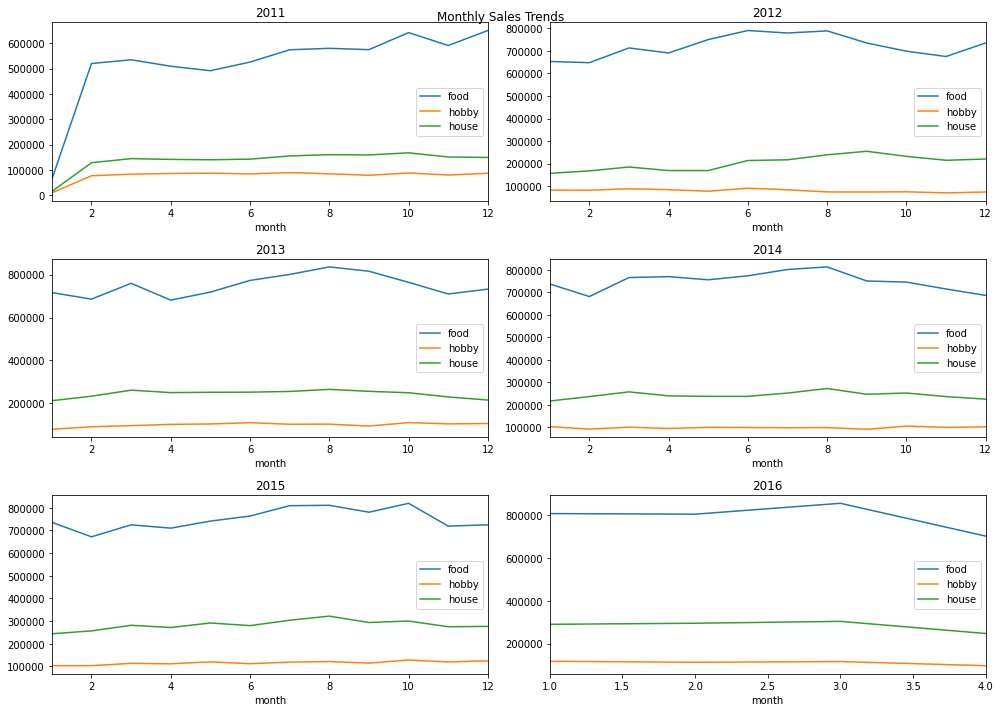

In [27]:
plot_trend(['food','hobby','house'],subplots = True)

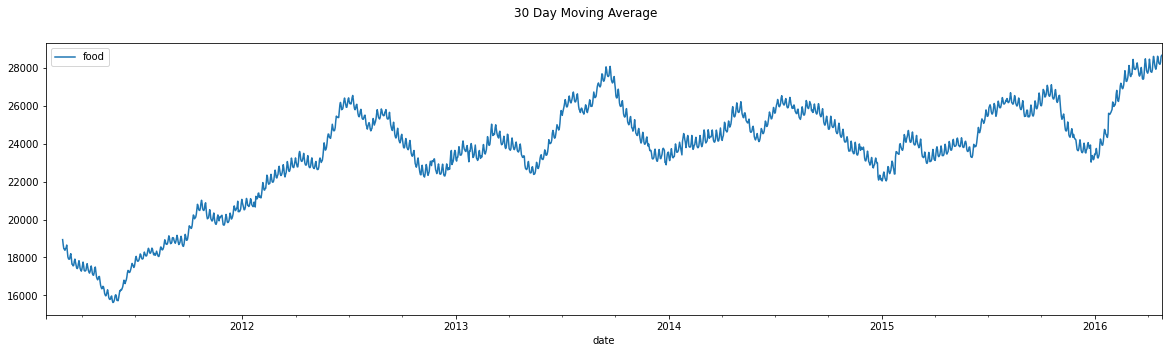

In [28]:
plot_trend(['food'],subplots = False)

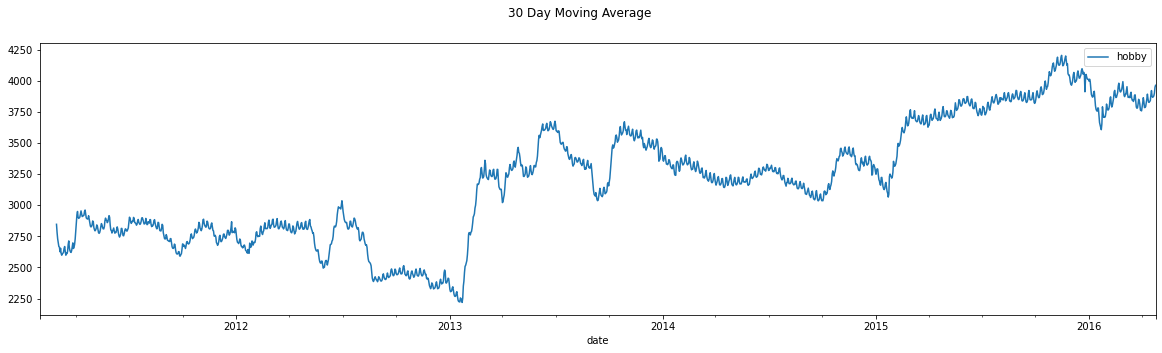

In [30]:
plot_trend(['hobby'],subplots = False)

Der kan ses en stiging i salget af hobbyartikler omkring starten af 2013, da det var året hvor den amerikanske økonomi begyndte at komme sig efter finanskrisen i 2009.

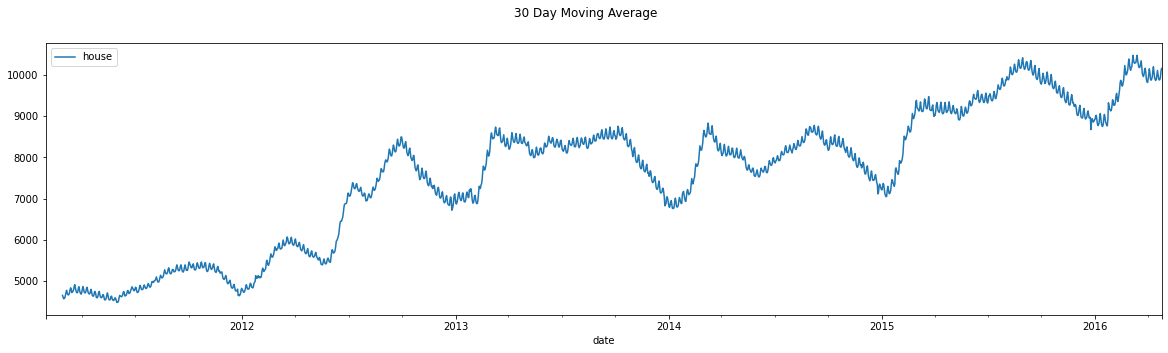

In [31]:
plot_trend(['house'],subplots = False)

## Analyse af time series

Fordi vi kan se det er et seasonal timeseries, en timeseries består af 3 systematiske komponenter, Trend, level, Seasonality og en ikke-systematisk komponent residuals, benytter vi seasonal_decompose for at undersøge disse.

Systematiske komponenter er dele af timeseries' der har konsistens eller optræder gentagne gange og kan beskrives og modelleres.

Ikke-systematiske komponenter er dele af timeseries der ikke kan modeleres direkte.

* Y[t] = T[t] + S[t] + e[t]

Trend er den voksende eller faldende værdi i datasættet.

Level er den gennemsnittelige værdi i datasættet.

Seasonality er gentagende short-term cycluser i datasættet.

Residuals er støjen der er i datasættet

Vi benytter additiv fordi det ligner at datasættet er lineært og ikke expotientielt.



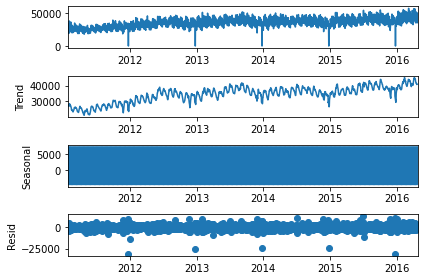

In [32]:
result = seasonal_decompose(sales_sum, model='additive')
result.plot()
plt.show()

In [33]:
calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'], usecols=['date','d'])
calendar_stv = calendar_df[:1913] 

sales_train_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv', index_col='id')

store_dept = sales_train_df.groupby(by= ['cat_id'], axis=0).mean()
store_dept.columns = calendar_stv['date']
store_trans = store_dept.transpose()

In [34]:
weekends = ['01-03-2015','01-04-2015','01-10-2015','01-11-2015','01-17-2015', '01-18-2015','01-24-2015', '01-25-2015', '01-31-2015', 
            '02-01-2015', '02-07-2015', '02-08-2015', '02-14-2015', '02-15-2015', '02-21-2015', '02-22-2015', '02-28-2015', 
            '03-01-2015', '03-07-2015', '03-08-2015', '03-14-2015', '03-15-2015', '03-21-2015', '03-22-2015', '03-28-2015',  '03-29-2015']

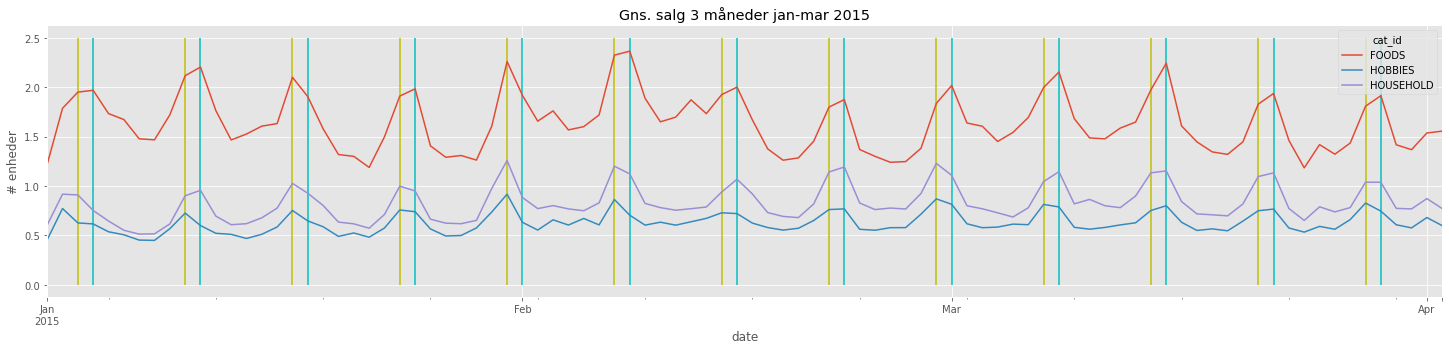

In [35]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [25, 5]
ax = store_trans['01-01-2015':'04-02-2015'].plot(title="Gns. salg 3 måneder jan-mar 2015")
ax.set_ylabel('# enheder')
ax.vlines(weekends, 0, 2.5, colors=['y','c'])
plt.show()

Vi kan se at der er en forøgning i salget omkring weekender, hvorfor man kan argumentere for at der er en seasonality på 7 dage, hvilket vi kan anvende i vores ARIMA model.

Vi vil starte med at forsøge at predicte på dataen med en ARIMA model

In [36]:
sales_train_validation.dtypes

id             object
item_id        object
dept_id        object
cat_id         object
store_id       object
                ...  
d_1910          int64
d_1911          int64
d_1912          int64
d_1913          int64
total_sales     int64
Length: 1920, dtype: object

In [37]:
train_dataset = sales_train_validation[date_col[-100:-30]]
val_dataset = sales_train_validation[date_col[-30:]]

Vi vælger at lave en sarimax model med en seasonality på 7, da vi ud fra vores tidligere anylyse har kunnet se en seasonality på 7 dage.


# ARIMA Model

[0 0 0 2 1 2 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 2 2 0 0 1 4 0 0 0 0 1 1 2 0
 4 0 1 0 1 4 2 0 2 0 1 1 0 1 0 0 1 1 3 0 0 0 1 1 1 3 1 3 1 2 2 0 1]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 6 1 1 2 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1]


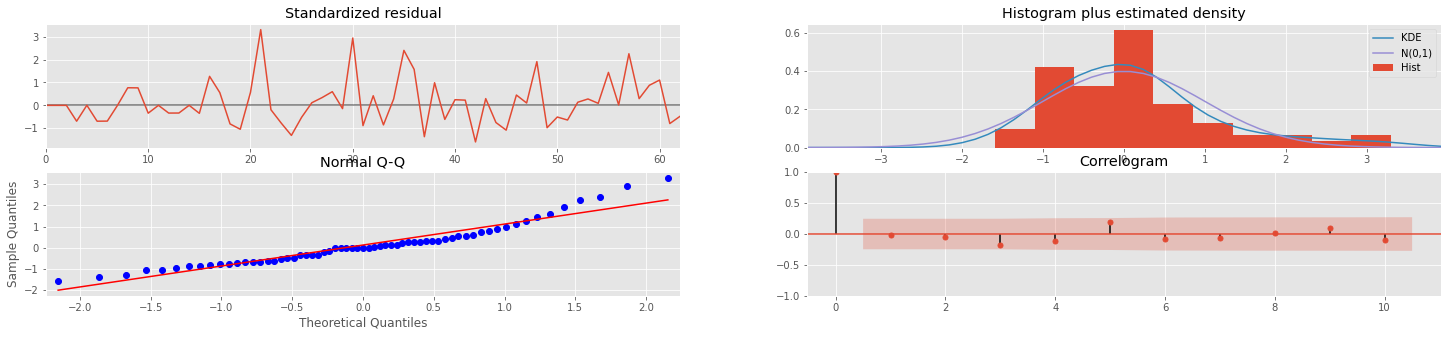

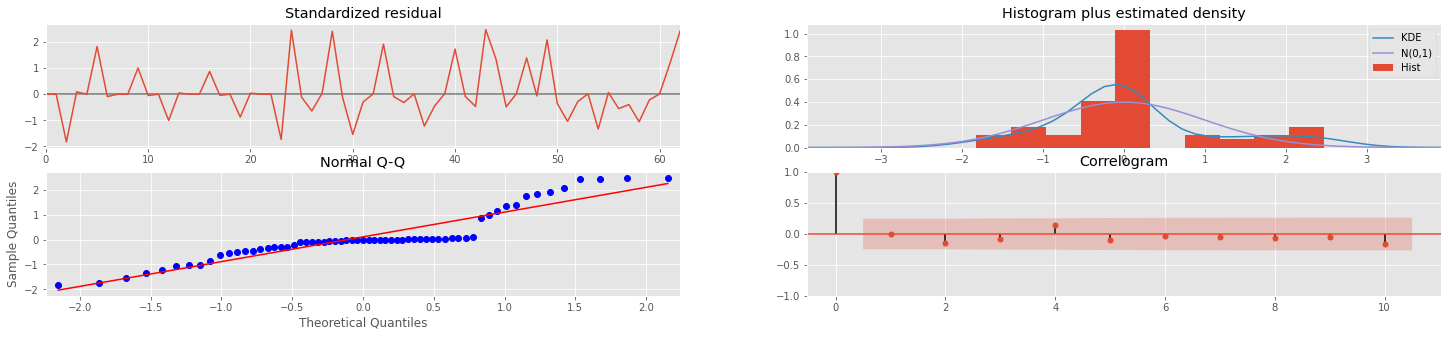

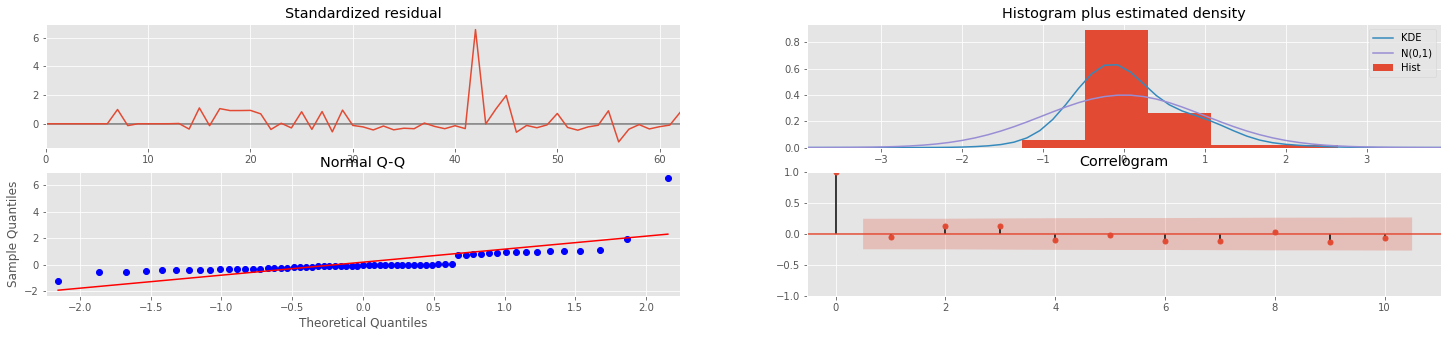

In [38]:
predictions = []
summary = []
##An ARMA model is an ARIMA model where the d parameter in the order is 0
for row in (train_dataset[train_dataset.columns[-100:]].values[:3]):
    print(row)
    fit = SARIMAX(row, seasonal_order=(1, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
    summary.append(fit.summary())
    fit.plot_diagnostics()
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

Vi kan se at på 2 ud af de 3 fittede modeler er det ikke særligt godt.


In [39]:
print(predictions)
print(summary)

[[ 1.08631894e+00  1.08387975e+00  8.08472546e-01  1.23277486e+00
   9.99895612e-01  6.75030476e-01  1.24918078e+00  1.09939920e+00
   8.57482739e-01  7.85841230e-01  1.14211740e+00  8.81720495e-01
   7.54793956e-01  1.27862467e+00  1.10094480e+00  8.30731038e-01
   7.83167051e-01  1.13140507e+00  8.67756595e-01  7.64219030e-01
   1.28210385e+00  1.10112743e+00  8.27569983e-01  7.82851063e-01
   1.13013927e+00  8.66106581e-01  7.65332723e-01  1.28251496e+00
   1.10114901e+00  8.27196464e-01]
 [ 3.18655128e-01  1.43132282e-01  3.57865142e-01  9.08250239e-02
  -9.04787664e-07  5.26030701e-01  9.14207462e-02  2.50757441e-01
   1.28739629e-01  3.26710653e-01  8.29378808e-02 -1.05767413e-06
   5.67164991e-01  1.70273474e-01  2.56650068e-01  1.29988722e-01
   3.29414453e-01  8.36223811e-02 -1.04440559e-06  5.63595075e-01
   1.63430095e-01  2.56138665e-01  1.29880318e-01  3.29179799e-01
   8.35629755e-02 -1.04555713e-06  5.63904897e-01  1.64024010e-01
   2.56183048e-01  1.29889726e-01]
 [ 9.6

Sammenligning af predictions mod de oprindelige værdier

In [40]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

Egentlig forecast til aflevering:

In [41]:
predict_dataset = sales_train_validation[sales_train_validation.columns[-500:]].values[:5]

print(predict_dataset)


[[   2    4    0 ...    1    1  600]
 [   0    1    0 ...    0    0  493]
 [   0    0    1 ...    1    1  288]
 [   5    9    0 ...    7    2 3288]
 [   1    3    2 ...    2    4 1849]]


Looper igennem alle produkter og foretager predictions med en sarimax '1 1 1 7' model for de næste 28 dage og gemmer dem i en liste kaldet results.

In [ ]:
#results = []
#for row in (sales_train_validation[sales_train_validation.columns[-100:]].values):
#    fit = SARIMAX(row, seasonal_order=(1, 1, 1, 7)).fit()
#    results.append(fit.forecast(28))
#print(results)

Det tog 2 timer at køre ovenstående (udkommenteret) vi har derfor gemt resultatet i en CSV til senere brug.

In [ ]:
results = genfromtxt("sarimax-predictions.csv", delimiter=',')

# Random Forest Model

Her 'cluster' vi data fra de 3 kategorier og de 3 stater i hver sit dataset, som vi så samler i 'clus'. 

In [ ]:
column_index = [1,2,3,4,5]
for i in range(6 , len(sales_train_validation.columns)):
    column_index.append(i)

clus_hobbies = sales_train_validation.iloc[:,column_index].query("cat_id == 'HOBBIES'")
clus_household = sales_train_validation.iloc[:,column_index].query("cat_id == 'HOUSEHOLD'")
clus_foods = sales_train_validation.iloc[:,column_index].query("cat_id == 'FOODS'")
clus_ca = sales_train_validation.iloc[:,column_index].query("state_id == 'CA'")
clus_tx = sales_train_validation.iloc[:,column_index].query("state_id == 'TX'")
clus_wi = sales_train_validation.iloc[:,column_index].query("state_id == 'WI'")
clus = sales_train_validation.iloc[:,column_index]

Tilføjer nye kolonner til calendar_data, med datoer opdelt. 

In [ ]:
calendar_data["event_type_1_snap"] = pd.notna(calendar_data["event_type_1"]) 
calendar_data["event_type_2_snap"] = pd.notna(calendar_data["event_type_2"]) 
calendar_data["date"] =  pd.to_datetime(calendar_data["date"])
calendar_data["d_month"] = calendar_data["date"].dt.day
calendar_data["year"] = pd.to_numeric(calendar_data["year"])
calendar_data["wday"] = pd.to_numeric(calendar_data["wday"])
print(calendar_data.shape)
calendar_data.head()

Samler kolonner efter månedens dage i et 'columnsets' data set.

In [ ]:
#Bucket columns by calander days of month
columnsets = []
for i in range(1,32):      
    d = calendar_data[:1913].query("d_month == "+ str(i))["d"]
    columnsets.append([d.values])


Metode til at encode de enkelte features til den rette datatype.

In [ ]:
# Label encoding for catagorical data
def label_encoding(data_preap,cat_features):
    categorical_names = {}
    data = []
    encoders = []
    
    data = data_preap[:]
    for feature in cat_features:
        le = LabelEncoder()
        le.fit(data.iloc[:,feature])
        data.iloc[:, feature] = le.transform(data.iloc[:, feature])
        categorical_names[feature] = le.classes_
        encoders.append(le)
    X_data = data.astype(float)
    return X_data, encoders

Metode til træning af RandomForestRegressor model med 350 træer. 

In [ ]:
# Training random forest model
def train_model(X_train, X_test, Y_train, Y_test):
    # Random forest regressor model with Training dataset
    start_time = datetime.today()
    regressor = RandomForestRegressor(n_estimators = 350, random_state = 50)
    regressor.fit(X_train,Y_train)

    print("Time taken to Train Model: " + str(datetime.today() - start_time))

    # Running Regession model score check
    Y_score = regressor.score(X_test,Y_test)
    return regressor,Y_score

Metode til at lave predictions på test data.

In [ ]:
# Predict function from model
def model_predict(regressor,X_data):
    # Predicting model model result
    Y_pred = regressor.predict(X_data)
    return Y_pred

Metode til at validere mod sidste års data

In [ ]:
# Validating model with last year data & generating rmse value for the model predection
def validate_model(regressor,X_validation, Y_validation):
   
    Y_validation_pred = model_predict(regressor, X_validation)
    mse = mean_squared_error(Y_validation, Y_validation_pred)
    rmse = np.sqrt(mse)
    return rmse, Y_validation_pred

Metode til at hente data fra en pandas Dataframe ud fra start og slut index

In [ ]:
# Basic function for geting data from pandas based on range
def get_data_range(Inital_Range,start_index,end_index):
    result = []
    [result.append(a) for a in Inital_Range]
    for i in range(max(Inital_Range) +1 + start_index, end_index):
        result.append(i)
    return result

Metode til at foretage predictions ud fra det originale data

In [ ]:
# main function to run predictions
def run_predictions(orig_data):
    process_data = orig_data[:]
    results = pd.DataFrame()
    for s in range(1,29):
        categorical_features = [0,1]
        data = []
        data_range = []
        for i in range(0,s):
            [data_range.append(a) for a in columnsets[i]]
        data_list = [process_data[a] for a in data_range]
        data  = pd.concat(data_list,axis = 1)


        data.insert(loc=0, column='item_id', value=process_data["item_id"])
        data.insert(loc=1, column='store_id', value=process_data["store_id"])
        X_data_preap = data[:]

        d = get_data_range(categorical_features,0,len(X_data_preap.columns)-1)   
        X,label_encoders = label_encoding(X_data_preap.iloc[:,d],categorical_features)
        Y = X.iloc[:,-1]

        d_validation = get_data_range(categorical_features,1,len(X_data_preap.columns))   
        X_validation,label_encoders_validation = label_encoding(X_data_preap.iloc[:,d_validation],categorical_features)
        Y_validation = X_validation.iloc[:,-1]

        print("Running Model for Day " + str(s))
        # Sampling data for train & split
        X_train, X_test, Y_train, Y_test = train_test_split(X.iloc[:,0:len(X.columns)-1],Y,test_size = 0.2, random_state = 0)
        model, score = train_model(X_train, X_test, Y_train, Y_test)
        print("Model Score: " + str(score))
        
       # Uncomment for inital model
        rmse,validation_predictions = validate_model(model,X_validation.iloc[:,0:len(X_validation.columns)-1], Y_validation)
        print("RMSE Result: " + str(rmse))
        
        if (len(results.columns) == 0):
            for feature in categorical_features:
                results[feature] = label_encoders_validation[feature].inverse_transform(X_validation.iloc[:,feature].astype(int))

        results["d_" + str(s)] = validation_predictions.astype(int)
        print(results)
        results.to_csv('pd_predictions_' + str(s) +'.csv')
    return results

Nedenstående laver predictions med en RandomForest model og gemmer resultatet i en variabel. Det tog i omegnen af 18 timer at eksekvere og er derfor udkommenteret. 

In [ ]:
#pd_predictions = run_predictions(clus)